# Resampling the ensemble generated by the NA direct-search

Authors: B. Bovy, J. Braun, A. Demoulin.

We perform here the resampling of the inversion ensemble using a Monte-Carlo Markov Chain (MCMC) sampler that is robust to highly correlated parameters.

## Motivation

The ensemble generated during the NA direct-search process presents well-defined but multiple regions of convergence (i.e., regions of high density of generated models). We want to quickly test whether we should interpret these regions of convergence as real local minima of the misfit function or as poorly sampled flat regions of the misfit reflecting the high correlation between some of the parameters (pseudo-convergence). 

Several arguments support the second hypothesis:

- Given our problem, it is likely to observe strong correlation between some of the parameters. Indeed, considering both the amount of production and transport of soil as unknowns should basically lead to an infinity of solutions, all emerging from the balance of production vs. transport that simulates the soil cover distribution that best fits the observed distribution. Likewise, including the initial soil thickness as a free parameter may in turn allow the soil production and transport parameters to vary so that we obtain similar distributions of soil thickness at the end of the simulation.
- The locations of the regions of convergence within the parameter space suggest correlations for some couples of parameters (especially the positive P_0 vs transport parameters relationships, with a few exceptions).  
- Besides the regions of convergence, we can observe in the scatterplots a few patterns that also suggest strong relationships between some parameters (e.g., P_0 vs. K_dd), although this is more subtle.
- At each of its iteration, the NA direct-search resampled only a limited number of Voronoi cells having the lowest misfit values of the ensemble. By design, the algorithm does not allow sampling new models outside of these cells at the next iterations. Despite our rather "explorative" tuning of the NA-parameters, it is possible that the number of resampled cells was not large enough to adequately cover elongated, flat regions of low misfit, hence the limited number of regions of convergence sparsely located. Increasing the number of resampled cells would have addressed this issue, but would also have drastically slowed down the convergence of the algorithm and exploded the computational demand. 


## Method

To test the hypothesis above at a reasonable computational cost, we define a process that is similar to the one described in the second paper of [Sambridge 1999](http://onlinelibrary.wiley.com/doi/10.1046/j.1365-246x.1999.00900.x/abstract) (appraising the inversion ensemble). We perform a resampling of the misfit function - more precisely, the posterior (\*) - using another technique that does not require any forward modelling, i.e., no new cliche simulation is made). It instead uses the NA-surface (i.e., the nearest neighbour approximation) built from the ensemble generated during the first stage (the NA direct search) to compute new values of the likelihood in the parameter space.

In his paper, M. Sambridge proposes using the (original) Gibbs sampler to generate a new ensemble made of a great number of models distributed like the posterior itself. However, it is known that the Gibbs sampler may not work properly in case of high posterior correlation between the parameters (see [here](http://www.bayesian-inference.com/mcmc) for details and references about the great variety of existing MCMC samplers). Using multiple independent samplers from different initial positions may partially address this issue (even though this is still debated). By design, however, the Gibbs sampler is not able to quickly explore a highly correlated joint-posterior outside of a (too) small region around its initial position. we therefore prefer to use a sampler which is more robust to that case: the Affine-Invariant Ensemble Sampler ([Goodman and Weare, 2010](http://msp.org/camcos/2010/5-1/p04.xhtml)). The Python package [emcee](http://dan.iel.fm/emcee/current/) implements this sampler.

Such a new resampled ensemble should provide us results that are more meaningful than the original ensemble. Indeed, the distribution of the newly generated models will be in principle similar to the posterior and will not suffer from the possible pseudo-convergence issue detailled above. It is worth noting, however, that the resampled ensemble does not provide any information that is not already included in the original ensemble (as no new cliche simulation is made here).

(\*) According to the Bayesian theorem, the posterior (or posterior density probability) corresponds to the product of the prior (which is constant within the parameter search space in our case) and the likelihood, up to a constant. In our problem, we simply define the (log-)likelihood by the negative of the misfit.    

## Process

Import the packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import NearestNDInterpolator

import emcee

import matplotlib.pyplot as plt
import pandas.tools.plotting as pdplt
import seaborn as sns

%matplotlib inline
pd.options.display.float_format = '{:,.3e}'.format
sns.set_context('notebook')
sns.set_style('darkgrid')
clr_plt = sns.color_palette()

Load the data from the original inversion ensemble. The outliers have been previously removed (see this [notebook](NA_Search_Analysis.ipynb)).

In [2]:
orig_ensemble = pd.read_csv("na_search_run20_clean.csv", index_col=0)

orig_ensemble.head()

,P_0,K_r12,K_d,K_dd,K_g,h_init,misfit,D_mean,RMSD,NA_iter
1,1.487e-04,1.084e-07,2.036e-02,4.449e-01,7.747e-03,8.720e-01,-3.513e+00,2.497e-01,1.291e-01,0.000e+00
2,2.338e-05,3.594e-07,3.650e-02,7.972e-03,1.972e-01,2.859e+00,-3.628e+00,1.993e-01,1.364e-01,0.000e+00
3,2.772e-06,4.159e-07,3.022e-02,6.722e-02,5.469e-02,2.360e+00,-2.026e+00,4.793e-01,2.774e-01,0.000e+00
4,1.315e-06,2.667e-04,4.319e-02,7.312e-03,4.953e-02,6.628e-01,-1.613e+00,6.412e-01,3.139e-01,0.000e+00
5,2.393e-05,1.757e-05,1.708e-04,3.365e-01,7.569e-03,8.483e-01,-2.086e+00,3.429e-01,3.340e-01,0.000e+00


Read the parameter search ranges and scales

In [3]:
p_ranges = pd.read_csv("na_p_ranges_run20.csv", index_col='name')

p_ranges

,min,max,log
name,,,
P_0,2.500e-07,2.500e-04,True
K_r12,1.000e-07,5.000e-04,True
K_d,1.000e-04,5.000e-02,True
K_dd,5.000e-04,5.000e-01,True
K_g,5.000e-04,1.000e+00,True
h_init,0.000e+00,3.000e+00,False


Functions to transform the scale of model parameters

In [4]:
def log_df(df):
    pnames = p_ranges[p_ranges['log']].index
    pnames_log = ["log({})".format(p) for p in pnames]
    
    df_log = df.copy()
    df_log.loc[:, pnames] = np.log(df.loc[:, pnames])
    df_log.rename(columns=dict(zip(pnames, pnames_log)),
                  inplace=True)
    
    return df_log

def delog_df(df_log):
    pnames = p_ranges[p_ranges['log']].index
    pnames_log = ["log({})".format(p) for p in pnames]
    
    df = df_log.copy()
    df.loc[:, pnames_log] = np.exp(df_log.loc[:, pnames_log])
    df.rename(columns=dict(zip(pnames_log, pnames)),
              inplace=True)
    
    return df


Initialize the nearest neighbour interpolator from the original inversion ensemble. It forms the NA approximation of the misfit.

In [25]:
orig_ensemble_log = log_df(orig_ensemble)

na_approx = NearestNDInterpolator(
    orig_ensemble_log.ix[:, 0:len(p_ranges)].values,
    #orig_ensemble_log['misfit'].values
    orig_ensemble_log['RMSD'].values * orig_ensemble_log['D_mean'].values
)

Set the log-prior: a uniform probability density within the bounded parameter search space

In [6]:
p_ranges_log = p_ranges.drop('log', axis=1)
islog = p_ranges['log'] == True 
p_ranges_log['min'][islog] = np.log(p_ranges_log['min'][islog])
p_ranges_log['max'][islog] = np.log(p_ranges_log['max'][islog])

p_ranges_log['prior'] = [
    stats.uniform(loc=pmin, scale=pmax - pmin)
    for pmin, pmax in p_ranges_log.values
]

def lnprior(m):
    lps = [p.logpdf(v)
           for (p, v) in zip(p_ranges_log['prior'], m)]
    if not np.all(np.isfinite(lps)):
        return -np.inf
    return np.sum(lps)

Set the log-likelihood: the negative of the misfit. Values are calculated from the NA approximation initialized above.

In [27]:
def lnlike(m):
    #return -na_approx(m)
    return -np.log(na_approx(m))

In [26]:
na_approx((-10, -10, -6, -3, -1, 2))

0.014508078030589603

In [28]:
lnlike((-10, -10, -6, -3, -1, 2))

4.2330496791233942

Set the log-posterior.

In [178]:
def lnprob(m):
    lp = lnprior(m)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(m)

Setup of the Affine-Invariant Ensemble Sampler: set the number and initial positions of the independent walkers. The initial positions are given by the models of lowest misfit after the 1st NA iteration in the original ensemble.

In [179]:
n_walkers = 200

orig_ensemble_iter0 = orig_ensemble.loc[orig_ensemble['NA_iter'] == 0]
sort_misift_idx = orig_ensemble_iter0.sort('misfit').index
init_idx = sort_misift_idx[:n_walkers]

init_walkers = log_df(orig_ensemble_iter0).ix[init_idx, 0:len(p_ranges)]

# uniform random initial positions
uniform_pos = np.column_stack([
    p.rvs(size=n_walkers) for p in p_ranges_log['prior']
])
init_walkers = pd.DataFrame(data=uniform_pos, columns=init_walkers.columns)

Initialize the `emcee` sampler and run the MCMC for `n_steps` iterations starting from the initial positions defined above. The total number of samples generated equals `n_steps * n_walkers / thin`.

In [180]:
sampler = emcee.EnsembleSampler(n_walkers, len(p_ranges), lnprob, threads=10)

n_steps = 2000
sampler.run_mcmc(init_walkers, n_steps, thin=5)

mcmc_samples = pd.DataFrame(sampler.flatchain,
                            columns=init_walkers.columns)

Plot the trace of the MCMC iterations.

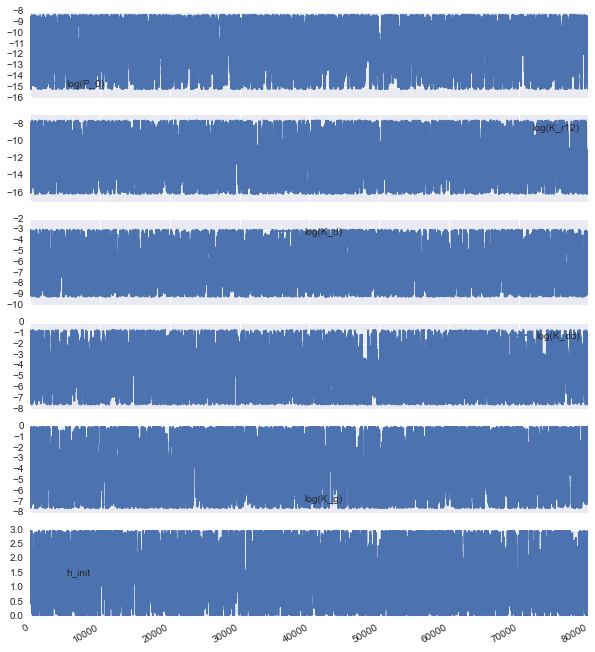

In [181]:
axes = mcmc_samples[:].plot(
    kind='line', subplots=True,
    figsize=(10, 12), color=clr_plt[0]
)

In [182]:
mcmc_kept_samples = mcmc_samples[:]

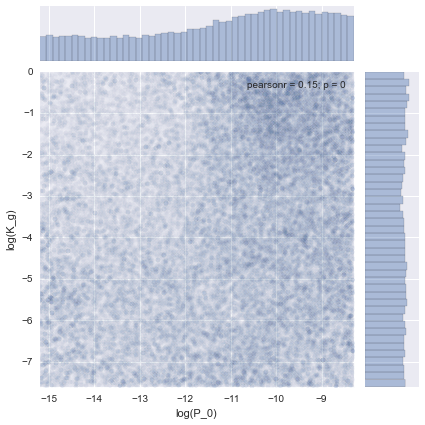

In [183]:
def jointplot_density(xcol, ycol):
    p = sns.jointplot(
        xcol, ycol,
        data=mcmc_kept_samples,
        xlim=(mcmc_kept_samples[xcol].min(),
              mcmc_kept_samples[xcol].max()),
        ylim=(mcmc_kept_samples[ycol].min(),
              mcmc_kept_samples[ycol].max()),
        joint_kws={'alpha': 0.02}
    )

jointplot_density('log(P_0)', 'log(K_g)')

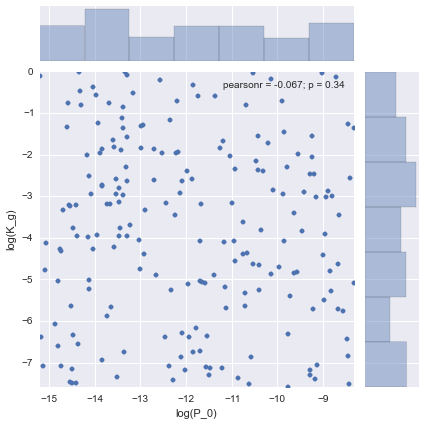

In [184]:
def jointplot_density_i(xcol, ycol):
    p = sns.jointplot(
        xcol, ycol,
        data=init_walkers,
        xlim=(init_walkers[xcol].min(),
              init_walkers[xcol].max()),
        ylim=(init_walkers[ycol].min(),
              init_walkers[ycol].max()),
    )
    
jointplot_density_i('log(P_0)', 'log(K_g)')